<a target="_blank" href="https://colab.research.google.com/github/giordamaug/HELP/blob/main/HELPpy/notebooks/gui.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/giordamaug/HELP/blob/main/HELPpy/notebooks/gui.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/>
</a>

### 1. Install HELP from GitHub
Skip this cell if you already have installed HELP.

In [ ]:
!pip install git+https://github.com/giordamaug/HELP.git

### 2. Download the input files
For a chosen tissue (here `Kidney`), download from GitHub the label file (here `Kidney_HELP.csv`, computed as in Example 1) and the attribute files (here BIO `Kidney_BIO.csv`, CCcfs `Kidney_CCcfs_1.csv`, ..., `Kidney_CCcfs_5.csv`, and N2V `Kidney_EmbN2V_128.csv`).  

Skip this step if you already have these input files locally.

In [ ]:
tissue='Kidney'
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_HELP.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_BIO.csv
for i in range(5):
  !wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_CCcfs_{i}.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_EmbN2V_128.csv

In [45]:
import ipywidgets as wid
from typing import List
import matplotlib.pyplot as plt
from HELPpy.models.labelling import labelling
from HELPpy.utility.selection import select_cell_lines, delrows_with_nan_percentage
from HELPpy.preprocess.loaders import feature_assemble_df
from HELPpy.models.prediction import VotingSplitClassifier, k_fold_cv
import pandas as pd
import numpy as np
import os, glob
from ipyfilechooser import FileChooser
from IPython.display import HTML as html_print
from IPython.display import display
from HELPpy.visualization.plot import svenn_intesect
from typing import List, Sequence, Iterable, Optional
import fnmatch

_LB_APPLY = 'Apply on'
_LB_DONE = 'DONE'
_LB_NANREM = 'Nan Removal'
_LB_FILTER = "Line Filtering"
_LB_LABEL = "Labelling"
_LB_SAVE = "Saving"
_LB_INPUT = "File input"
_LB_SELGENE = "Select genes directory"
_LB_CNGGENE = "Change genes directory"
_LB_SELATTR = "Select attribute directory"
_LB_CNGATTR = "Change attribute directory"
_LB_SEL_LAB = "Select label directory"
_LB_CNG_LAB = "Change label directory"
_LB_SELGENE_SUB = "Select genes to subtract"
_LB_CNGGENE_SUB = "Change genes to subtract"
_LB_SEL_ATTR = "Loading attributes"
_LB_CNG_ATTR = "Change attributes"
_LB_SEL_LAB = "Select labelling"
_LB_CNG_LAB = "Change labelling"
_LB_LOAD_LABFILE = "Loading label file"
_LB_VALID = "Validation"
_LB_PREPROC = "Preprocessing"
_LB_PREDICT = "Prediction"
_LB_INTERSET = "Intersection"
_LB_IDENTIFY = "Identification"
_LB_CNG_FILE1 = "Change CRISPR file"
_LB_SEL_FILE1 = "Select CRISPR file"
_LB_CNG_FILE2 = "Change Model file"
_LB_SEL_FILE2 = "Select Model file"

def file_with_ext(path, extension='.csv'):
    file_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(extension):
                file_list.append(file)
    return file_list

def match_item(item: str, filter_pattern: Sequence[str]) -> bool:
    """Check if a string matches one or more fnmatch patterns."""
    if isinstance(filter_pattern, str):
        filter_pattern = [filter_pattern]
    idx = 0
    found = False
    while idx < len(filter_pattern) and not found:
        found |= fnmatch.fnmatch(item.lower(), filter_pattern[idx].lower())
        idx += 1
    return found

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

def print_color(t):
    display(html_print(' '.join([cstr(ti, color=ci) for ti,ci in t])))
    
def pipeline(path: str=os.getcwd(), savepath: str=os.getcwd(), labelpath: str=os.getcwd(), filename: str='', modelname:str='', labelname:str='', rows: int=5, minlines=10, percent = 100.0, line_group='OncotreeLineage', line_col='ModelID', verbose=False):
    """
    Generate an interactive widget for labeling cell lines based on specified criteria.

    Parameters
    ----------
    path : str
        path for input file loading.
    filename : str
        name of CRISPR effect input file.
    modelname : str
        name of Model input file.
    rows : int, optional
        The number of rows to display in the widget for selecting tissues (default is 5).
    minlines : int, optional
        Minimum number of cell lines for tissue/lineage to be considered (default is 1).
    line_group : str, optional
        The column in 'df_map' to use for tissue selection (default is 'OncotreeLineage').
    line_col : str, optional
        The column in 'df_map' to use for line selection (default is 'ModelID').

    Returns
    -------
    ipywidgets.ValueWidget
        Widget containing the labeled cell lines.
    """
    tabs = wid.Tab()
    df_map = None
    df = None
    df_orig = None
    val = wid.ValueWidget()
    val.value = None, df, df_orig, df_map 
    tissue_list = []
    selector_list = []

    nanrem_set = wid.SelectionSlider(
        options=range(0, 101),
        value=int(percent),
        description='Nan %:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        tooltip='set percentage of nan allowed in genes',
    )
    def nanrem_set_changed(b):
        try:
            df_orig = val.value[2]
            df = delrows_with_nan_percentage(df_orig, perc=float(nanrem_set.value))
            try:
                df_map = val.value[3]
                tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) 
                               if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
                seltissue.options = ['__all__'] +  tissue_list
                seltissue.value=['__all__']
                val.value = val.value[0], df[np.intersect1d(df.columns,df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
            except:
                val.value = val.value[0], df, val.value[2], val.value[3]
            with out3:
                out3.clear_output()
                print_color(((f'Removed {len(df_orig)-len(df)}/{len(df_orig)} rows (with at least {nanrem_set.value}% NaN)', 'green'),))
            Vb1.set_title(0, f"{_LB_NANREM} ({nanrem_set.value})")
        except:
            pass 
    nanrem_set.observe(nanrem_set_changed, names='value')

    minline_set = wid.SelectionSlider(
        options=range(1, 100),
        value=minlines,
        description='Min lines:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        tooltip='set minimum number of lines for the tissue',
    )
    def minline_set_changed(b):
        try:
            tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
            seltissue.options = ['__all__'] +  tissue_list
            seltissue.value=['__all__']
            val.value = val.value[0], df[np.intersect1d(df.columns, df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
            Vb1.set_title(1, f"{_LB_FILTER} (Lines: {minline_set.value})")
        except:
            val.value = val.value[0], df, val.value[2], val.value[3]
            with out1:
                out1.clear_output()
                print_color(((f'Problem processing map file ...', 'red'),)) 
    minline_set.observe(minline_set_changed, names='value')
    selselector = wid.Dropdown(
        options=['__all__'] + selector_list,
        value='__all__',
        description='Selector:',
        tooltip = 'select the group type of lines',
        disabled=False,
    )
    def selselector_changed(b):
        df = val.value[1]
        df_map = val.value[3]
        if selselector.value != ():
            try:
                tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
                seltissue.options = ['__all__'] +  tissue_list
                seltissue.value=['__all__']
                val.value = val.value[0], df[np.intersect1d(df.columns, df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
            except:
                val.value = val.value[0], df, val.value[2], val.value[3]
                with out1:
                    out1.clear_output()
                    print_color(((f'Problem processing map file ...', 'red'),)) 
            with out1:
                out1.clear_output()
                display(selselector.value)
          
    selselector.observe(selselector_changed, names='value')
    seltissue = wid.SelectMultiple(
        options=['__all__'] + tissue_list if tissue_list != [] else [],
        value=['__all__'] if tissue_list != [] else [],
        rows=rows,
        description=line_group if line_group in selselector.options else '',
        tooltip = 'select lines by the chosen group',
        disabled=False
    )
    def seltissue_changed(b):
        if seltissue.value != ():
            if seltissue.value == ('__all__',):
                fname = f"{selselector.value}_all{'_mom' if selmode_button.value else ''}.csv"
                fc3._filename.value = fname
            else:
                fname = f"{selselector.value}_{'_'.join([str(s).replace(' ','-').replace('/','-') for s in seltissue.value if str(s) != '__all__'])}.csv"
                fc3._filename.value = fname
            fc3._apply_selection()
        with out1:
            out1.clear_output()
            print_color(((f"{','.join(seltissue.value)}", "orange"),))
    seltissue.observe(seltissue_changed, names='value')
    # IDENTIFICATION TAB
    fc3 = FileChooser(path, title='Choose file', filter='*.csv', layout=wid.Layout(width='auto'))
    def fc3_change_title(fc3):
        if os.path.isfile(fc2.selected):
            fc3._label.value = fc3._LBL_TEMPLATE.format(f'{fc3.selected}', 'green')
            Vb4.set_title(1, f"{_LB_SAVE} ({fc3.selected_filename})")
        else:
            fc3._label.value = fc3._LBL_TEMPLATE.format(f'{fc3.selected} not a file', 'red')
            Vb4.set_title(1, f"{_LB_SAVE}")
    fc3.register_callback(fc3_change_title)
    saveto_but = wid.Button(description="Save ...", button_style='primary')
    def on_savebutton_clicked(b):
        if isinstance(val.value[0], pd.DataFrame):
            try:
                fc3._label.value = fc3._LBL_TEMPLATE.format(f'{fc3.selected}', 'orange')
                val.value[0].to_csv(fc3.selected, index=True)
                fc3._label.value = fc3._LBL_TEMPLATE.format(f'{fc3.selected}', 'green')
            except:
                fc3._label.value = fc3._LBL_TEMPLATE.format(f'Problem saving {fc3.selected}!', 'green')
                with out4:
                    out4.clear_output()
                    print_color(((f'Problem saving label file (maybe empty)!', 'red'),))
            with out4:
                out4.clear_output()
        else:
            with out4:
                out4.clear_output()
                print_color(((f'Label dataframe is null (apply labelling before saving)!', 'red'),))
    saveto_but.on_click(on_savebutton_clicked)

    mode_buttons = wid.RadioButtons(
        options=["E|NE", "E|aE|sNE", "E|(aE|sNE)"],
        value='E|NE',
        description='',
        tooltips=['2 classes (one division)', '3 classes (one division)', '3 classes (two-times subdivision)'],
    )
    selmode_button = wid.Checkbox(
        value=False,
        description='Nested',
        disabled=False,
        indent=False
    )
    button = wid.Button(description=_LB_APPLY, button_style='primary')
    def on_button_clicked(b):
        df = val.value[1]
        df_map = val.value[3]
        with out1:
            out1.clear_output()
            print_color(((f'Labelling {len(df)} genes of {",".join(seltissue.value)} ...', 'orange'),))
        with out2:
            out2.clear_output()
            if seltissue.value == ('__all__',):
                selector = [x for x in seltissue.options if x != '__all__']
            else:
                selector = [x for x in seltissue.value if x != '__all__']
            cell_lines = select_cell_lines(df, df_map, selector, line_group=line_group, line_col=line_col, 
                                            nested = selmode_button.value, verbose=verbose)
            if mode_buttons.value == "E|(aE|sNE)":
                mode = 'two-by-two' 
                nclasses = 3
                labelnames = {0: 'E', 1: 'aE', 2: 'sNE'}
            else:
                mode = 'flat-multi' 
                if mode_buttons.value == "E|NE":
                    nclasses = 2
                    labelnames = {0: 'E', 1: 'NE'}
                else:
                    nclasses = 3
                    labelnames = {0: 'E', 1: 'aE', 2: 'sNE'}
            val.value = labelling(df, columns=cell_lines, mode=mode, n_classes=nclasses, labelnames=labelnames, verbose=verbose), df, val.value[2], val.value[3]
        with out1:
            out1.clear_output()
            print_color(((_LB_DONE, 'green'),))

    button.on_click(on_button_clicked)
    out1 = wid.Output()
    out2 = wid.Output()
    out3 = wid.Output()
    out4 = wid.Output()
    out6 = wid.Output()
    out7 = wid.Output()

    # INPUT TAB
    if filename != '':
        fc1 = FileChooser(path, filter='*.csv', filename=filename, select_default=True, layout=wid.Layout(width='auto'))
        try:
            df_orig = pd.read_csv(fc1.selected).rename(columns={'Unnamed: 0': 'gene'}).rename(columns=lambda x: x.split(' ')[0]).set_index('gene').T
            df = delrows_with_nan_percentage(df_orig, perc=float(nanrem_set.value))
            df_map = val.value[3]
            val.value = val.value[0],df, df_orig, val.value[3]
            with out3:
                out3.clear_output()
                print_color(((f'Removed {len(df_orig)-len(df)}/{len(df_orig)} rows (with at least {nanrem_set.value}% NaN)', 'green'),))
            if df_map is not None and len(np.unique(df_map[line_group].dropna().values)) > 0:
                try:
                    tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
                    seltissue.options = ['__all__'] + tissue_list
                    seltissue.value=['__all__']
                    val.value = val.value[0], df[np.intersect1d(df.columns, df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
                except:
                    val.value = val.value[0], df, val.value[2], val.value[3]
                    fc1._label.value = fc1._LBL_TEMPLATE.format(f'Problem reading {fc1.selected} file ...', 'red') 
            fc1._label.value = fc1._LBL_TEMPLATE.format(f'{fc1.selected}', 'green')
        except:
            fc1._label.value = fc1._LBL_TEMPLATE.format(f'Problem loading {fc1.selected} file ...', 'red') 
    else:
        fc1 = FileChooser(path, filter='*.csv', layout=wid.Layout(width='auto'))
    
    def fc1_change_title(fc1):
        try:
            df_orig = pd.read_csv(fc1.selected).rename(columns={'Unnamed: 0': 'gene'}).rename(columns=lambda x: x.split(' ')[0]).set_index('gene').T
            df = delrows_with_nan_percentage(df_orig, perc=float(nanrem_set.value))
            df_map = val.value[3]
            val.value = val.value[0],df ,df_orig, val.value[3]
            with out3:
                out3.clear_output()
                print_color(((f'Removed {len(df_orig)-len(df)}/{len(df_orig)} rows (with at least {nanrem_set.value}% NaN)', 'green'),))
            if df_map is not None and len(np.unique(df_map[line_group].dropna().values)) > 0:
                try:
                    tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
                    seltissue.options = ['__all__'] + tissue_list
                    seltissue.value=['__all__']
                    val.value = val.value[0], df[np.intersect1d(df.columns, df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
                except:
                    val.value = val.value[0], df, val.value[2], val.value[3]
                    fc1._label.value = fc1._LBL_TEMPLATE.format(f'Problem reading {fc1.selected} file ...', 'red') 
            fc1._label.value = fc1._LBL_TEMPLATE.format(f'{fc1.selected}', 'green')
            Vb2.set_title(0, f"{_LB_CNG_FILE1} ({fc1.selected_filename})")
        except:
            fc1._label.value = fc1._LBL_TEMPLATE.format(f'Problem loading {fc1.selected} file ...', 'red') 

    fc1.register_callback(fc1_change_title)
    # PREPROCESSING TAB
    if modelname != '':
        fc2 = FileChooser(path, filter='*.csv', filename=modelname, select_default=True, layout=wid.Layout(width='auto'))
        try:
            df_map = pd.read_csv(fc2.selected)
            df = val.value[1]
            val.value = val.value[0], val.value[1] ,val.value[2], df_map
            selselector.options = list(df_map.columns)
            selselector.value = line_group if line_group in selselector.options else selselector.options[0]
            if len(np.unique(df_map[selselector.value].dropna().values)) > 0:
                try:
                    tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
                    seltissue.options = ['__all__'] + tissue_list
                    seltissue.value=['__all__']
                    val.value = val.value[0], df[np.intersect1d(df.columns, df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
                except:
                    val.value = val.value[0], df, val.value[2], val.value[3]
                    fc2._label.value = fc2._LBL_TEMPLATE.format(f'Problem reading {fc2.selected} file ...', 'red') 
            fc2._label.value = fc2._LBL_TEMPLATE.format(f'{fc2.selected}', 'green')
        except:
            fc2._label.value = fc2._LBL_TEMPLATE.format(f'Problem loading {fc2.selected} file ...', 'red') 
    else:
        fc2 = FileChooser(path, filter='*.csv', layout=wid.Layout(width='auto'))
    def fc2_change_title(fc2):
        try:
            df_map = pd.read_csv(fc2.selected)
            df = val.value[1]
            val.value = val.value[0], val.value[1] ,val.value[2], df_map
            selselector.options = list(df_map.columns)
            selselector.value = line_group if line_group in selselector.options else selselector.options[0]
            if len(np.unique(df_map[selselector.value].dropna().values)) > 0:
                try:
                    tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
                    seltissue.options = ['__all__'] + tissue_list
                    seltissue.value=['__all__']
                    val.value = val.value[0], df[np.intersect1d(df.columns, df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
                except:
                    val.value = val.value[0], df, val.value[2], val.value[3]
                    fc2._label.value = fc2._LBL_TEMPLATE.format(f'Problem reading {fc2.selected} file ...', 'red') 
            fc2._label.value = fc2._LBL_TEMPLATE.format(f'{fc2.selected}', 'green')
            Vb2.set_title(1, f"{_LB_CNG_FILE2} ({fc2.selected_filename})")
        except:
            fc2._label.value = fc2._LBL_TEMPLATE.format(f'Problem loading {fc2.selected} file ...', 'red') 
    fc2.register_callback(fc2_change_title)
    # INTERSECTION TAB
    def fc4_change_title(fc4):
        if not os.path.isdir(fc4.selected):
            fc4._label.value = fc4._LBL_TEMPLATE.format(f'{fc4.selected}... not a directory!', 'red')
            Vb6.set_title(0, f"{_LB_SELGENE}")
        else:
            try:
                files.options = file_with_ext(fc4.selected, extension='.csv')
                fc4._label.value = fc4._LBL_TEMPLATE.format(f'{fc4.selected}', 'green')
                Vb6.set_title(0, f"{_LB_CNGGENE} ({os.path.basename(fc4.selected)})")
            except:
                fc4._path_label.value = fc4._LBL_TEMPLATE.format(f'{fc4.selected}', 'red') 
                Vb6.set_title(0, f"{_LB_SELGENE}")
    fc4 = FileChooser(savepath, filter='*.csv', default_path=savepath, show_only_dirs = True, layout=wid.Layout(width='auto'))
    fc4.register_callback(fc4_change_title)
    fc4._filename.value = os.path.basename(savepath)
    fc4._apply_selection()

    fc5 = FileChooser(filter='*.csv', default_path=savepath, layout=wid.Layout(width='auto'))
    def fc5_change_title(fc5):
        if os.path.isfile(fc5.selected) and match_item(fc5.selected, '*.csv'):
            fc5._label.value = fc5._LBL_TEMPLATE.format(f'{fc5.selected}', 'green')
            Vb6.set_title(1, f"{_LB_CNGGENE_SUB} ({fc5.selected_filename})")
        else:
            fc5._label.value = fc5._LBL_TEMPLATE.format(f'{fc5.selected}', 'red')
            Vb6.set_title(1, f"{_LB_SELGENE_SUB}")
    fc5.register_callback(fc5_change_title)

    files = wid.SelectMultiple(
        description='Label Files:',
        options=[f for f in file_with_ext(savepath, extension='.csv')]
    )
    setbut = wid.Button(description="Intersect ...", button_style='primary')
    def on_setbut_clicked(b):
        try:
            csEGs = []
            for f in files.value:
                dfl = pd.read_csv(os.path.join(fc4.selected,f), index_col=0)
                csEG = dfl[dfl['label'] == 'E'].index.values
                if fc5.selected is not None and os.path.isfile(fc5.selected):
                    df_common = pd.read_csv(os.path.join(savepath,fc5.selected), index_col=0)
                    cEG = df_common[df_common['label']=='E'].index.values
                    csEG = np.setdiff1d(csEG, cEG)
                csEGs += [set(csEG)]
            with out6:
                out6.clear_output()
                display(svenn_intesect(csEGs, labels=[x.split('.')[0] for x in files.value], ylabel='EGs', figsize=(10,4)))
        except Exception as e:
            with out6:
                out6.clear_output()
                print_color(((f'Problem processing label files!', 'red'),))
                print_color(((f'{e}', 'black'),))

    setbut.on_click(on_setbut_clicked)
    # PREDICTION TAB
    fc6 = FileChooser(path, default_path=path, show_only_dirs = True, layout=wid.Layout(width='auto'))
    def fc6_change_title(fc6):
        if not os.path.isdir(fc6.selected):
            fc6._label.value = fc6._LBL_TEMPLATE.format(f'{fc6.selected}... not a directory!', 'red')
            Vb7.set_title(0, f"{_LB_SELATTR}")
        else:
            try:
                attrfiles.options = file_with_ext(fc6.selected, extension='.csv')
                fc6._label.value = fc6._LBL_TEMPLATE.format(f'{fc6.selected}', 'green')
                Vb7.children[0].set_title(0, f"{_LB_CNGATTR} ({os.path.basename(fc6.selected)})")
            except:
                fc6._path_label.value = fc6._LBL_TEMPLATE.format(f'{fc6.selected}', 'red') 
                Vb7.children[0].set_title(0, f"{_LB_SELATTR}")
    fc6.register_callback(fc6_change_title)
    fc6._filename.value = os.path.basename(path)
    fc6._apply_selection()
    if labelname != '':
        fc7 = FileChooser(labelpath, filter='*.csv', filename=labelname, select_default=True, layout=wid.Layout(width='auto'))
        try:
            fc7._label.value = fc7._LBL_TEMPLATE.format(f'{fc7.selected}', 'green')
        except:
            fc7._label.value = fc7._LBL_TEMPLATE.format(f'Problem loading {fc7.selected} file ...', 'red') 
    else:
        fc7 = FileChooser(labelpath, filter='*.csv', layout=wid.Layout(width='auto'))

    def fc7_change_title(fc7):
        if os.path.isfile(fc7.selected):
            fc7._label.value = fc7._LBL_TEMPLATE.format(f'{fc7.selected}', 'green')
            Vb7.children[0].set_title(1, f"{_LB_CNG_LAB} ({os.path.basename(fc7.selected)})")
        else:
            fc7._label.value = fc7._LBL_TEMPLATE.format(f'{fc7.selected}', 'red')
            Vb7.children[0].set_title(1, f"{_LB_SEL_LAB}")
    fc7.register_callback(fc7_change_title)
    attrfiles = wid.SelectMultiple(
        description='Attribute Files:',
        options=[f for f in file_with_ext(labelpath, extension='.csv')],
        disable=True
    )
    valbut = wid.Button(description="Validate ...", button_style='primary')
    def on_valbut_clicked(b):
        try:
            with out7:
                out7.clear_output()
                print_color(((f'Validating model ...', 'orange'),))
            features = [{'fname': os.path.join(fc6.selected, f), 'fixna' : False, 'normalize': 'std'} for f in attrfiles.value]
            df_y = pd.read_csv(fc7.selected, index_col=0)
            df_y = df_y.replace({'aE': 'NE', 'sNE': 'NE'})
        except Exception as e:
            with out7:
                out7.clear_output()
                print_color(((f'Problem processing label files!', 'red'),))
                print_color(((f'{e}', 'black'),))
        try:
            df_X, df_y = feature_assemble_df(df_y, features=features, saveflag=False, verbose=False)
        except Exception as e:
            with out7:
                out7.clear_output()
                print_color(((f'Problem assembling attributes files!', 'red'),))
                print_color(((f'{e}', 'black'),))
        try:
            clf = VotingSplitClassifier(n_voters=10, n_jobs=-1, random_state=-1)
            with out7:
                out7.clear_output()
                df_scores, scores, predictions = k_fold_cv(df_X, df_y, clf, n_splits=5, seed=0, verbose=True)
                out7.clear_output()
                print_color(((_LB_DONE, 'green'),))
                display(df_scores)
        except Exception as e:
            with out7:
                out7.clear_output()
                print_color(((f'Problem in validation!', 'red'),))
                print_color(((f'{e}', 'black'),))


    valbut.on_click(on_valbut_clicked)

    # MAIN WIDGET GUI    
    Vb2 = wid.Accordion(children=[fc1, fc2])
    Vb2.set_title(0, f"{_LB_SEL_FILE1}") if fc1.selected_filename == "" else Vb2.set_title(0, f"{_LB_CNG_FILE1} ({fc1.selected_filename})")
    Vb2.set_title(1, f"{_LB_SEL_FILE2}") if fc2.selected_filename == "" else Vb2.set_title(1, f"{_LB_CNG_FILE2} ({fc2.selected_filename})")
    Vb1 = wid.Accordion(children=[wid.VBox([nanrem_set, out3]), wid.VBox([minline_set, selselector, wid.HBox([seltissue, selmode_button])])])
    Vb1.set_title(0, f"{_LB_NANREM} ({percent}%)")
    Vb1.set_title(1, f"{_LB_FILTER} (Lines: {minline_set.value})")
    acd4 = wid.Accordion(children=[mode_buttons, wid.HBox([fc3, saveto_but,out4])])
    acd4.set_title(0, f"{_LB_LABEL} ({mode_buttons.value})")
    acd4.set_title(1, f"{_LB_SAVE}") if fc3.selected_filename == "" else acd4.set_title(1, f"{_LB_SAVE} ({fc3.selected_filename})")
    Vb4 = wid.HBox([acd4, wid.VBox([wid.HBox([button, out1]), out2])]) 
    acd6 = wid.Accordion(children=[wid.HBox([fc4, files]), fc5])
    acd6.set_title(0, f"{_LB_SELGENE}") if fc4.selected_path == "" else acd6.set_title(0, f"{_LB_CNGGENE} ({os.path.basename(fc4.selected_path)})")
    acd6.set_title(1, f"{_LB_SELGENE_SUB}") if fc5.selected_filename is None else Vb6.set_title(1, f"{_LB_CNGGENE_SUB} ({fc5.selected_filename})")
    Vb6 = wid.HBox([acd6, wid.VBox([setbut, out6])])
    acd7 = wid.Accordion(children=[wid.HBox([fc6,attrfiles], layout={'flex-flow': 'flex-wrap'}), fc7])
    acd7.set_title(0, f"{_LB_SEL_ATTR}") if fc6.selected_path == "" else acd7.set_title(0, f"{_LB_CNG_ATTR} ({os.path.basename(fc6.selected_path)})")
    acd7.set_title(1, f"{_LB_SEL_LAB}") if fc7.selected_filename is None else acd7.set_title(1, f"{_LB_CNG_LAB} ({fc7.selected_filename})")
    Vb7 = wid.HBox([acd7,wid.VBox([valbut, out7])])
    tabs.children = [Vb2, Vb1, Vb4, Vb6, Vb7]
    tabs.set_title(0, f'{_LB_INPUT}')
    tabs.set_title(1, f'{_LB_PREPROC}')
    tabs.set_title(2, f'{_LB_IDENTIFY}')
    tabs.set_title(3, f'{_LB_INTERSET}')
    tabs.set_title(4, f'{_LB_PREDICT}')
    display(tabs)
    return val

Observe that the CCcfs file has been subdivided into 5 separate files for storage limitations on GitHub. 

### 3. Load the input files
Load the CRISPR data and show the content.

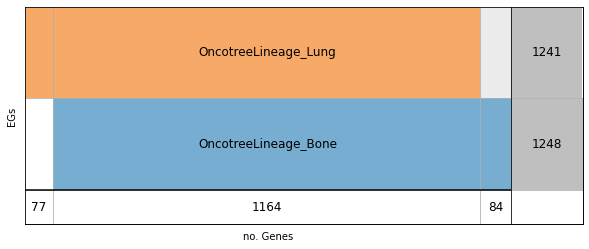

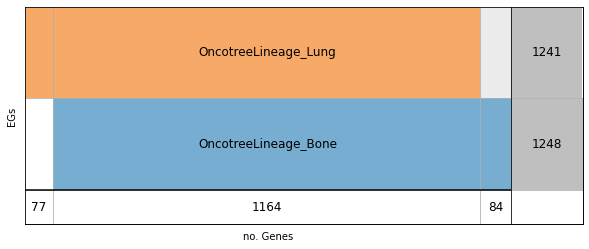

In [46]:
from HELPpy.visualization.ui import Help_Dashboard
w = pipeline(path='../../data', savepath='../../newdata',
             filename='CRISPRGeneEffect.csv', 
             modelname='Model.csv', labelname='Lung_HELP.csv', labelpath='../../data',
             line_group='OncotreeLineage', verbose=False, percent=80)

In [3]:
len(w.value[1]), w.value[0].value_counts()

(17931,
 label
 NE       16683
 E         1248
 dtype: int64)